# ETAPA DE ENTRENAMIENTO Y TESTEO.

In [1]:
! pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
from google.colab import files
import random
import pickle
import matplotlib.pyplot as plt
import gensim
import multiprocessing as mp
import shutil
import os

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
from tensorflow.keras.optimizers import Adam

FUNCIONES

In [3]:
def generate_tokenizer(train_df, val_df, test_df):
    #creamos el vocabulario (tenemos palabra y número)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df)
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Total words: {vocab_size}")

    # Convertimos los datos de entrenamiento en secuencias de índices usando el tokenizer
    X_train_seq = tokenizer.texts_to_sequences(train_df)
    X_val_seq = tokenizer.texts_to_sequences(val_df)
    X_test_seq = tokenizer.texts_to_sequences(test_df)

    return tokenizer, vocab_size, X_train_seq, X_val_seq, X_test_seq


In [4]:
def generate_word2vec(train_series):
    documents = [text.split() for text in train_series]
    w2v_model = gensim.models.word2vec.Word2Vec(
        vector_size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        workers=mp.cpu_count(),
    )
    w2v_model.build_vocab(documents)

    vocab_size = len(w2v_model.wv)
    print(f"Vocab size: {vocab_size}")
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    return w2v_model


In [5]:
def generate_embedding(word2vec_model, vocab_size, tokenizer):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return Embedding(
        vocab_size,
        W2V_SIZE,
        weights=[embedding_matrix],
        input_length=SEQUENCE_LENGTH,
        trainable=False,
    )


In [6]:
# Conecto al drive y guardo el archivo
drive.mount('/content/drive')

# Decargamos el dataframe ya preprocesado
music_df_process = pd.read_csv('/content/drive/MyDrive/music_df_process.csv')

Mounted at /content/drive


In [7]:
music_df_process.shape

(99820, 2)

## MODELADO

### Separamos el conjunto de train y test

In [8]:
# Separamos los datos con entrenamiento 75% y test 25%

X_train, X_test, y_train, y_test = train_test_split(
    music_df_process['review_norm'],
    music_df_process['sentiment'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True)

In [9]:
X_train.iloc[:10]

81645    clue bought sent complaint string buzzing sent...
75919         good throne little cash good short stint kit
51804    bad price better unit gone step work use flore...
69730                     string ball end clear unable use
75563           strap slide pad shouldar strap rubing neck
44577                     incredibly effective expectation
49286                                                 toot
70446    thought nice balanced set string bite lower st...
15513    bought friend saw heard sound asked order far ...
75399    microphone work start loose tried screw broke ...
Name: review_norm, dtype: object

In [10]:
y_train.iloc[:10]

81645    0
75919    0
51804    0
69730    0
75563    0
44577    1
49286    1
70446    0
15513    1
75399    0
Name: sentiment, dtype: int64

Para problemas de clasificación binaria supervisada, TfidfTransformer se prefiere sobre CountVectorizer porque tiende a dar mejores resultados al penalizar las palabras comunes y destacar las palabras más importantes y distintivas para cada clase.

### Extracción de features

In [11]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=5000,
    strip_accents='ascii',
    ngram_range=(1, 3)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=5000, min_df=3, ngram_range=(1, 3),
                strip_accents='ascii')

In [12]:
print(list(cv.vocabulary_.items())[:20])

[('clue', 713), ('bought', 378), ('sent', 3746), ('complaint', 763), ('string', 4167), ('buzzing', 510), ('new', 2806), ('worst', 4924), ('previous', 3250), ('horrible', 2039), ('build', 461), ('waste', 4777), ('money', 2716), ('buy', 489), ('waste money', 4778), ('money buy', 2718), ('good', 1636), ('throne', 4423), ('little', 2421), ('cash', 579)]


In [13]:
print(len(cv.vocabulary_))

5000


In [14]:
# TF-IDF scores del training set y test set

X_train_ml = cv.transform(X_train)
X_test_ml = cv.transform(X_test)

## Score IDF de algunas palabras

In [15]:
words_example = [
    'data',
    'hook',
    'product',
    'class',
    'normal',
    'value',
    'sound',
    'feel',
    ]

In [16]:
vocab_idf = dict(zip(cv.get_feature_names_out(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
data                8.198
hook                6.543
product             OOV                 
class               6.297
normal              5.985
value               5.346
sound               2.703
feel                4.142


Aqui observamos como la palabra 'product' ha sido eliminadas en el notebook anterior entendiendo que no aportan nada a nuestro vocabulario.

## Palabras con el TF-IDF en alguna review

In [17]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 55936
Sentiment: 1
Review: great tone electric guitar slightly darker glass use depending tone play slide pinky size fit


In [18]:
doc_vector = X_train_ml[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 5
print('Top {} words with highest TF-IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF-IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 5 words with highest TF-IDF in the review 55936:
             tfidf
tone      0.343276
pinky     0.337713
size fit  0.330129
darker    0.313439
glass     0.291468

Top 5 words with lowest TF-IDF in the review 55936:
           tfidf
fit     0.157166
play    0.142388
use     0.118179
guitar  0.117380
great   0.104870


## $\chi²$ scores

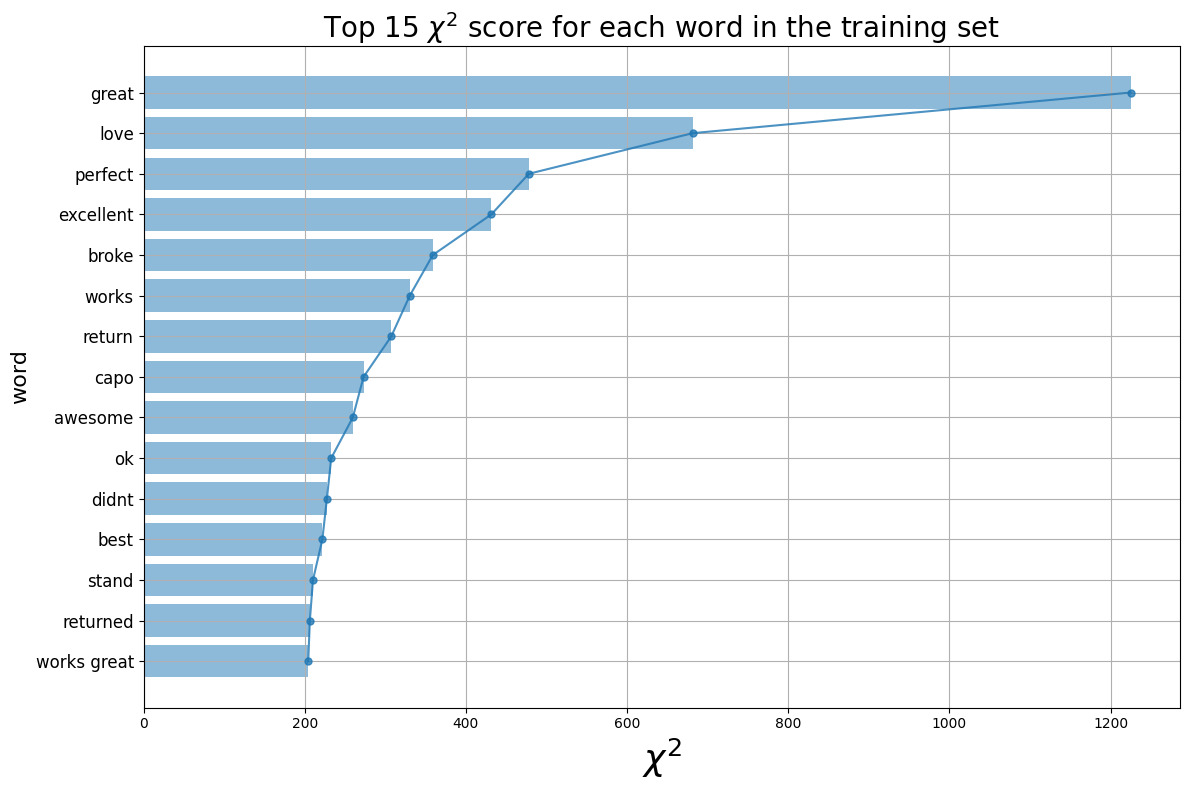

In [19]:
i = 15

chi2score = chi2(X_train_ml, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

### Entrenamiento con Logistic Regression

In [20]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100]

train_acc = []
test_acc = []
for c in c_params:
    lr_model = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    # Realizar validación cruzada
    cv_scores = cross_val_score(lr_model, X_train_ml, y_train, cv=5)

    # Calcular la precisión media en validación cruzada
    cv_mean = cv_scores.mean()

    lr_model.fit(X_train_ml, y_train)
    test_predict = lr_model.predict(X_test_ml)

    # Calcular la precisión en los datos de prueba
    test_accuracy = accuracy_score(y_test, test_predict)

    print("C={}, CV Accuracy Mean: {:.4f}, Test Accuracy: {:.4f}".format(c, cv_mean, test_accuracy))

    train_acc.append(cv_mean)
    test_acc.append(test_accuracy)

C=0.01, CV Accuracy Mean: 0.8084, Test Accuracy: 0.8111
C=0.05, CV Accuracy Mean: 0.8317, Test Accuracy: 0.8319
C=0.25, CV Accuracy Mean: 0.8479, Test Accuracy: 0.8484
C=0.5, CV Accuracy Mean: 0.8523, Test Accuracy: 0.8534
C=1, CV Accuracy Mean: 0.8549, Test Accuracy: 0.8536
C=10, CV Accuracy Mean: 0.8506, Test Accuracy: 0.8497
C=100, CV Accuracy Mean: 0.8443, Test Accuracy: 0.8466


In [21]:
# Guardamos el modelo en un archivo
with open('/content/drive/My Drive/lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Guardar los conjuntos de entrenamiento y prueba transformados con TfidfVectorizer
with open('/content/drive/My Drive/X_train_ml.pkl', 'wb') as f:
    pickle.dump(X_train_ml, f)

with open('/content/drive/My Drive/X_test_ml.pkl', 'wb') as f:
    pickle.dump(X_test_ml, f)

# Guardar las listas train_acc y test_acc
with open('/content/drive/My Drive/train_acc.pkl', 'wb') as f:
    pickle.dump(train_acc, f)

with open('/content/drive/My Drive/test_acc.pkl', 'wb') as f:
    pickle.dump(test_acc, f)

# Guardar el vectorizador en un archivo
with open('/content/drive/My Drive/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)

### Entrenamiento con Deep learning

In [22]:
# Separamos los datos con entrenamiento 75% y test 25%
X_train, X_test, y_train, y_test = train_test_split(
    music_df_process['review_norm'],
    music_df_process['sentiment'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True)

# Separamos el conjunto de entrenamiento nuevamente, en train 85% y validación 15%
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    train_size=0.85,
    test_size=0.15,
    random_state=42,
    shuffle=True)

# Imprimo las cardinalidades de los conjuntos
print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_val.shape, y_val.shape)
print("Prueba:", X_test.shape, y_test.shape)

Entrenamiento: (63635,) (63635,)
Validación: (11230,) (11230,)
Prueba: (24955,) (24955,)


In [23]:
# Calculo la media y el máximo de palabras por reviews.

max = 0
mean = []
for example in X_train:
  length = len(example)
  mean.append(len(example))
  if length > max:
    max = length

In [24]:
sum(mean) / len(mean)

144.17565804981535

In [25]:
max

7430

In [26]:
# Parámetros del WORD2VEC

W2V_SIZE = 350
W2V_WINDOW = 10

W2V_EPOCH = 10
W2V_MIN_COUNT = 2

# KERAS

SEQUENCE_LENGTH = 350

In [27]:
# Tokenizamos y calculamos el total del vocabulario

tokenizer, vocab, X_train_seq, X_val_seq, X_test_seq = generate_tokenizer(X_train, X_val, X_test)

Total words: 44123


In [28]:
# Generamos el modelo Word2Vec

word2vec_model = generate_word2vec(X_train)

Vocab size: 19896


In [29]:
# Generamos el embedding

embedding_layer = generate_embedding(word2vec_model, vocab, tokenizer)

In [30]:
# nos aseguramos de que todas las secuencias tengan la misma longitud

X_train_pad = pad_sequences(X_train_seq, maxlen=SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_seq, maxlen=SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=SEQUENCE_LENGTH)

In [31]:
# Modelo de Deep Learning + embedding propio

model_custom = Sequential()
model_custom.add(embedding_layer)
model_custom.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_custom.add(Dense(1, activation="sigmoid"))

model_custom.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 350)          15443050  
                                                                 
 lstm (LSTM)                 (None, 100)               180400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 15623551 (59.60 MB)
Trainable params: 180501 (705.08 KB)
Non-trainable params: 15443050 (58.91 MB)
_________________________________________________________________


In [32]:
model_custom.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [34]:
# Entrenamos el modelo

batch_size = 512
num_epochs = 20

model_custom.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), batch_size=batch_size, epochs=num_epochs)

Epoch 1/20
125/125 [==============================] - 140s 1s/step - loss: 0.3791 - accuracy: 0.8331 - val_loss: 0.3529 - val_accuracy: 0.8456
Epoch 2/20
125/125 [==============================] - 131s 1s/step - loss: 0.3451 - accuracy: 0.8503 - val_loss: 0.3417 - val_accuracy: 0.8511
Epoch 3/20
125/125 [==============================] - 130s 1s/step - loss: 0.3286 - accuracy: 0.8574 - val_loss: 0.3320 - val_accuracy: 0.8535
Epoch 4/20
125/125 [==============================] - 128s 1s/step - loss: 0.3155 - accuracy: 0.8641 - val_loss: 0.3252 - val_accuracy: 0.8603
Epoch 5/20
125/125 [==============================] - 126s 1s/step - loss: 0.3029 - accuracy: 0.8706 - val_loss: 0.3307 - val_accuracy: 0.8545
Epoch 6/20
125/125 [==============================] - 129s 1s/step - loss: 0.2924 - accuracy: 0.8759 - val_loss: 0.3226 - val_accuracy: 0.8588
Epoch 7/20
125/125 [==============================] - 128s 1s/step - loss: 0.2795 - accuracy: 0.8811 - val_loss: 0.3299 - val_accuracy: 0.8594

In [35]:
# Evaluamos el modelo en los datos de prueba

test_loss, test_accuracy = model_custom.evaluate(X_test_pad, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

780/780 [==============================] - 79s 101ms/step - loss: 0.3997 - accuracy: 0.8529
Test Loss: 0.39973825216293335
Test Accuracy: 0.852895200252533


In [38]:
# Guardamos el modelo Word2Vec
word2vec_model.save('/content/drive/MyDrive/word2vec_model.h5')

# Guardamos el modelo del RNN
model_custom.save('rnn_w2v_model.h5')

shutil.move('rnn_w2v_model.h5', '/content/drive/MyDrive/')

# Guardamos los conjuntos de entrenamiento y prueba
with open('/content/drive/MyDrive/X_train_pad.pkl', 'wb') as f:
    pickle.dump(X_train_pad, f)

with open('/content/drive/MyDrive/X_val_pad.pkl', 'wb') as f:
    pickle.dump(X_val_pad, f)

with open('/content/drive/MyDrive/X_test_pad.pkl', 'wb') as f:
    pickle.dump(X_test_pad, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
